# Project 15.32: Overcoming critical slowing down

Author: Tianlu Liu, YiTao Huang

Date: June 2024

Environment: Python 3.13, C++17

----

Project 15.32 primarily focuses on addressing the "critical slowing down" problem encountered when simulating the Ising model near its critical point using Monte Carlo methods.

As the system approaches the critical temperature $T_c$, the correlation length $\xi(T)$ increases sharply as

$$
\xi(T) \sim L \sim |T - T_c|^{-\nu}
$$

with $\nu = 1$ for the two-dimensional Ising model. The autocorrelation time $\tau(T)$ is given by

$$
\tau(T) \sim \xi(T)^z \sim |T - T_c|^{-z\nu}
$$

where $z \approx 2.167$ for single-spin-flip update.

This leads to a significant drop in efficiency for conventional local dynamics algorithms—such as the Metropolis single-spin-flip update when the temperature is close to $T_c$ or the system size $L$ grows.

The goal of this project is to explore and implement a cluster-flipping algorithms (Wolff algorithm), which simultaneously flip groups of correlated spins to effectively mitigate critical slowing down. This approach aims to enhance simulation efficiency and enable the study of both static and dynamic properties of the two-dimensional Ising model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import njit
from tqdm import tqdm
from ising_model import *


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'sans-serif'


J_val = 1.0  # ferromagnetic case
k_B = 1.0 # normalize Boltzmann constant

The Wolff algorithm has been implemented in C++, here just gives the cardinal procedures (in the view of programming):
1. Creat a set *cluster* and a deque *check*, both initialized as empty
2. Randomly select a spin as the seed, add it to both *cluster* and *check*
3. While *check* is not empty:
   1. Pop the first spin from *check* as *current*
   2. Consider the four nearest neighbors of *current* as *neighbors*
   3. For each *neighbor* in *neighbors*, if *neighbor* has **the same spin** as *current* and is not in *cluster*, add it to *cluster* and the tail of *check* with probability
    $$P_{\text{add}} = 1 - e^{-2J/k_BT}$$
4. Flip all spins in *cluster*

Steps 1-4 constitute one Wolff update. Repeat for sufficient times to achieve equilibrium configuration.

## Critical Slowing Down

Since the autocorrelation time is needed immediately in the sampling process, we first define the autocorrelation function and the autocorrelation time below. The scaling law of the autocorrelation time will be discussed later.

The autocorrelation function $C(t)$ for a time series of measurements $O_i$ is defined as:

$$
C(t) = \frac{\langle O_i O_{i+t} \rangle - \langle O_i \rangle^2}{\langle O_i^2 \rangle - \langle O_i \rangle^2}
$$

The autocorrelation time $\tau$ is then defined as the integral of the autocorrelation function:

$$
\tau = \sum_{t=1} C(t)
$$

and Tthe sum is cut off at the first negative value of $C(t)$.

In [2]:
@njit
def autocorr_func(x):
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n
    acf = np.zeros(n)
    for lag in range(n):
        c_lag = np.sum((x[:n - lag] - x_mean) * (x[lag:] - x_mean)) / n
        acf[lag] = c_lag / c0
    return acf

@njit
def integrated_autocorr_time(acf):
    tau = 0.5  # Start with the zero lag
    for lag in range(1, len(acf)):
        if acf[lag] <= 0:
            break
        tau += acf[lag]
    return tau

To facilitate simulation more conveniently, we encapsulate the simplest multiple-flip process with three components: thermalization, measurement, and sampling based on the autocorrelation time.

In [3]:
def sim_ising(s, kBT, n_therm, n_meas, method = "metropolis", lag = 1):
    multipleSteps(s, kBT, n_therm, method, False)
    e_seq, m_seq, cluster_sizes = multipleSteps(s, kBT, n_meas, method, True, lag)
    return e_seq, m_seq, cluster_sizes


In [282]:
L = 16
T = np.arange(1.8, 2.8, 0.1)

steps_wolff_thermal = 100
steps_wolff = 200
steps_metro_thermal = 200 * L * L
steps_metro = 300 * L * L

tau_wolff = []
tau_metro = []
cluster_sizes = []

pbar = tqdm(T, desc="Metropolis")
for t in pbar:
    tau_metro_val = 0
    for _ in range(30):  # repeat to avoid outliers
        s = IsingSpins(L, L, J_val)
        e_samples, m_samples, _ = sim_ising(s, t, steps_metro_thermal, steps_metro, method="metropolis", lag=L*L)
        acf_metro = autocorr_func(m_samples)
        tau_metro_val += integrated_autocorr_time(acf_metro)
    tau_metro.append(tau_metro_val / 30) 
pbar.close()

pbar = tqdm(T, desc="Wolff")
for t in pbar: 
    tau_wolff_val = 0
    cluster_val = 0
    for _ in range(30):  # single run is sufficient
        s = IsingSpins(L, L, J_val)
        e_samples, m_samples, cluster_size = sim_ising(s, t, steps_wolff_thermal, steps_wolff, method="wolff", lag=1)
        acf_wolff = autocorr_func(m_samples)
        tau_wolff_val += integrated_autocorr_time(acf_wolff)
        cluster_val += cluster_size

    tau_wolff.append(tau_wolff_val / 30)  
    cluster_sizes.append(cluster_val / 30)
pbar.close()

print('tau_metropolis:\n', tau_metro)
print('tau_wolff:\n', tau_wolff)
print('cluster_sizes:\n', cluster_sizes)

Wolff: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

tau_metropolis:
 [1.1453490987103998, 1.5009637072127286, 3.5468131064033153, 4.944046432847428, 10.095853540958508, 16.387484317367054, 17.832659935727985, 17.15857292387233, 13.063862448628203, 9.716402966402717]
tau_wolff:
 [0.557758975819212, 0.6132840727794185, 0.729471291849622, 1.0146910615876532, 1.5269795867476004, 2.3679701999991156, 2.3071587813981638, 2.2300009539533554, 2.1466259848050715, 2.0238645323630724]
cluster_sizes:
 [234.9, 224.76666666666668, 212.66666666666666, 194.4, 166.06666666666666, 125.03333333333333, 83.23333333333333, 51.4, 33.0, 22.466666666666665]


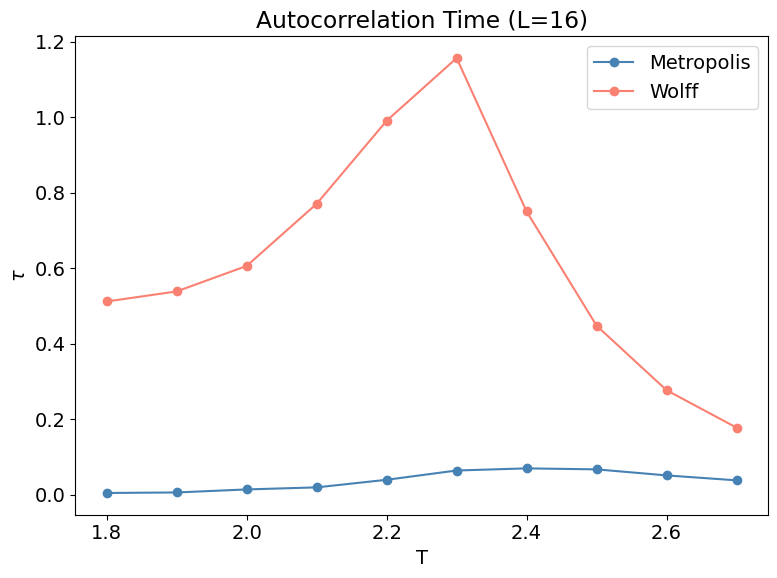

In [283]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(T, np.array(tau_metro)/(L*L), 'o-', label='Metropolis', color='steelblue')
ax.plot(T, np.array(tau_wolff)*np.array(cluster_sizes)/(L*L), 'o-', label='Wolff', color='salmon')
ax.set_xlabel('T')
ax.set_ylabel(r'$\tau$') 
ax.set_title(f'Autocorrelation Time (L={L})')
ax.legend()
plt.tight_layout()
plt.show()

## Simple Comparison

From the results below, it is evident that the Wolff algorithm is significantly more efficient than the Metropolis algorithm, especially near the critical temperature. As we can see
$$
\tau_{\text{metro}} > 10 L^2
$$
around $T_c$. In contrast, the Wolff algorithm maintains a much lower autocorrelation time. In single spin flip view, autocorr time of Wolff can be written as 
$$
\tau_{\text{wolff, single}} = \tau_{\text{wolff}}\times p \approx L^2
$$

where $p$ is the average cluster size.

In the simulations below, for the Wolff algorithm, we perform thermalization over $60\tau_{\text{wolff}}$, followed by $3000\tau_{\text{wolff}}$ of evolution and measurement in the thermalized state, sampling every $2\tau_{\text{wolff}}$, this ensures that the samples are essentially independent.

For the Metropolis algorithm, the choices for thermalization and sampling intervals are identical to those used in the Wolff algorithm; however, the total evolution time for measurements is set to $3000\tau_{\text{wolff}}\times p_{\text{size}}$, sothat they have the same total number of spin flips.


In [292]:
L = 16
T = np.arange(1.8, 2.8, 0.1)

data_metro = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

# ---- metropolis simulation ----#
pbar = tqdm(T, desc='Metropolis')
for t in pbar:
    i = np.where(T == t)[0][0]
    steps_metro_themal = int(100 * tau_metro[i] * L * L)
    steps_metro = int(3000 * tau_metro[i] * L * L)

    s = IsingSpins(L, L, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * t, steps_metro_themal, steps_metro, 'metropolis', int(2*tau_metro[i]*L*L))
    data_metro['energy'].append(np.mean(e_sam))
    data_metro['energy_std'].append(np.std(e_sam))
    data_metro['magnetization'].append(np.mean(m_sam))
    data_metro['magnetization_std'].append(np.std(m_sam))
pbar.close()

# ---- wolff simulation ----#
pbar = tqdm(T, desc='Wolff')
for t in pbar:
    i = np.where(T == t)[0][0]

    steps_wolff_thermal = int(100 * tau_wolff[i])
    steps_wolff = int(3000 * tau_wolff[i]) 

    s_w = IsingSpins(L, L, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * t, steps_wolff_thermal, steps_wolff, 'wolff', int(np.ceil(2*tau_wolff[i])))
    
    data_wolff['energy'].append(np.mean(e_sam))
    data_wolff['energy_std'].append(np.std(e_sam))
    data_wolff['magnetization'].append(np.mean(m_sam))
    data_wolff['magnetization_std'].append(np.std(m_sam))
    data_wolff['cluster_size'].append(cluster_size)
pbar.close()

Wolff: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


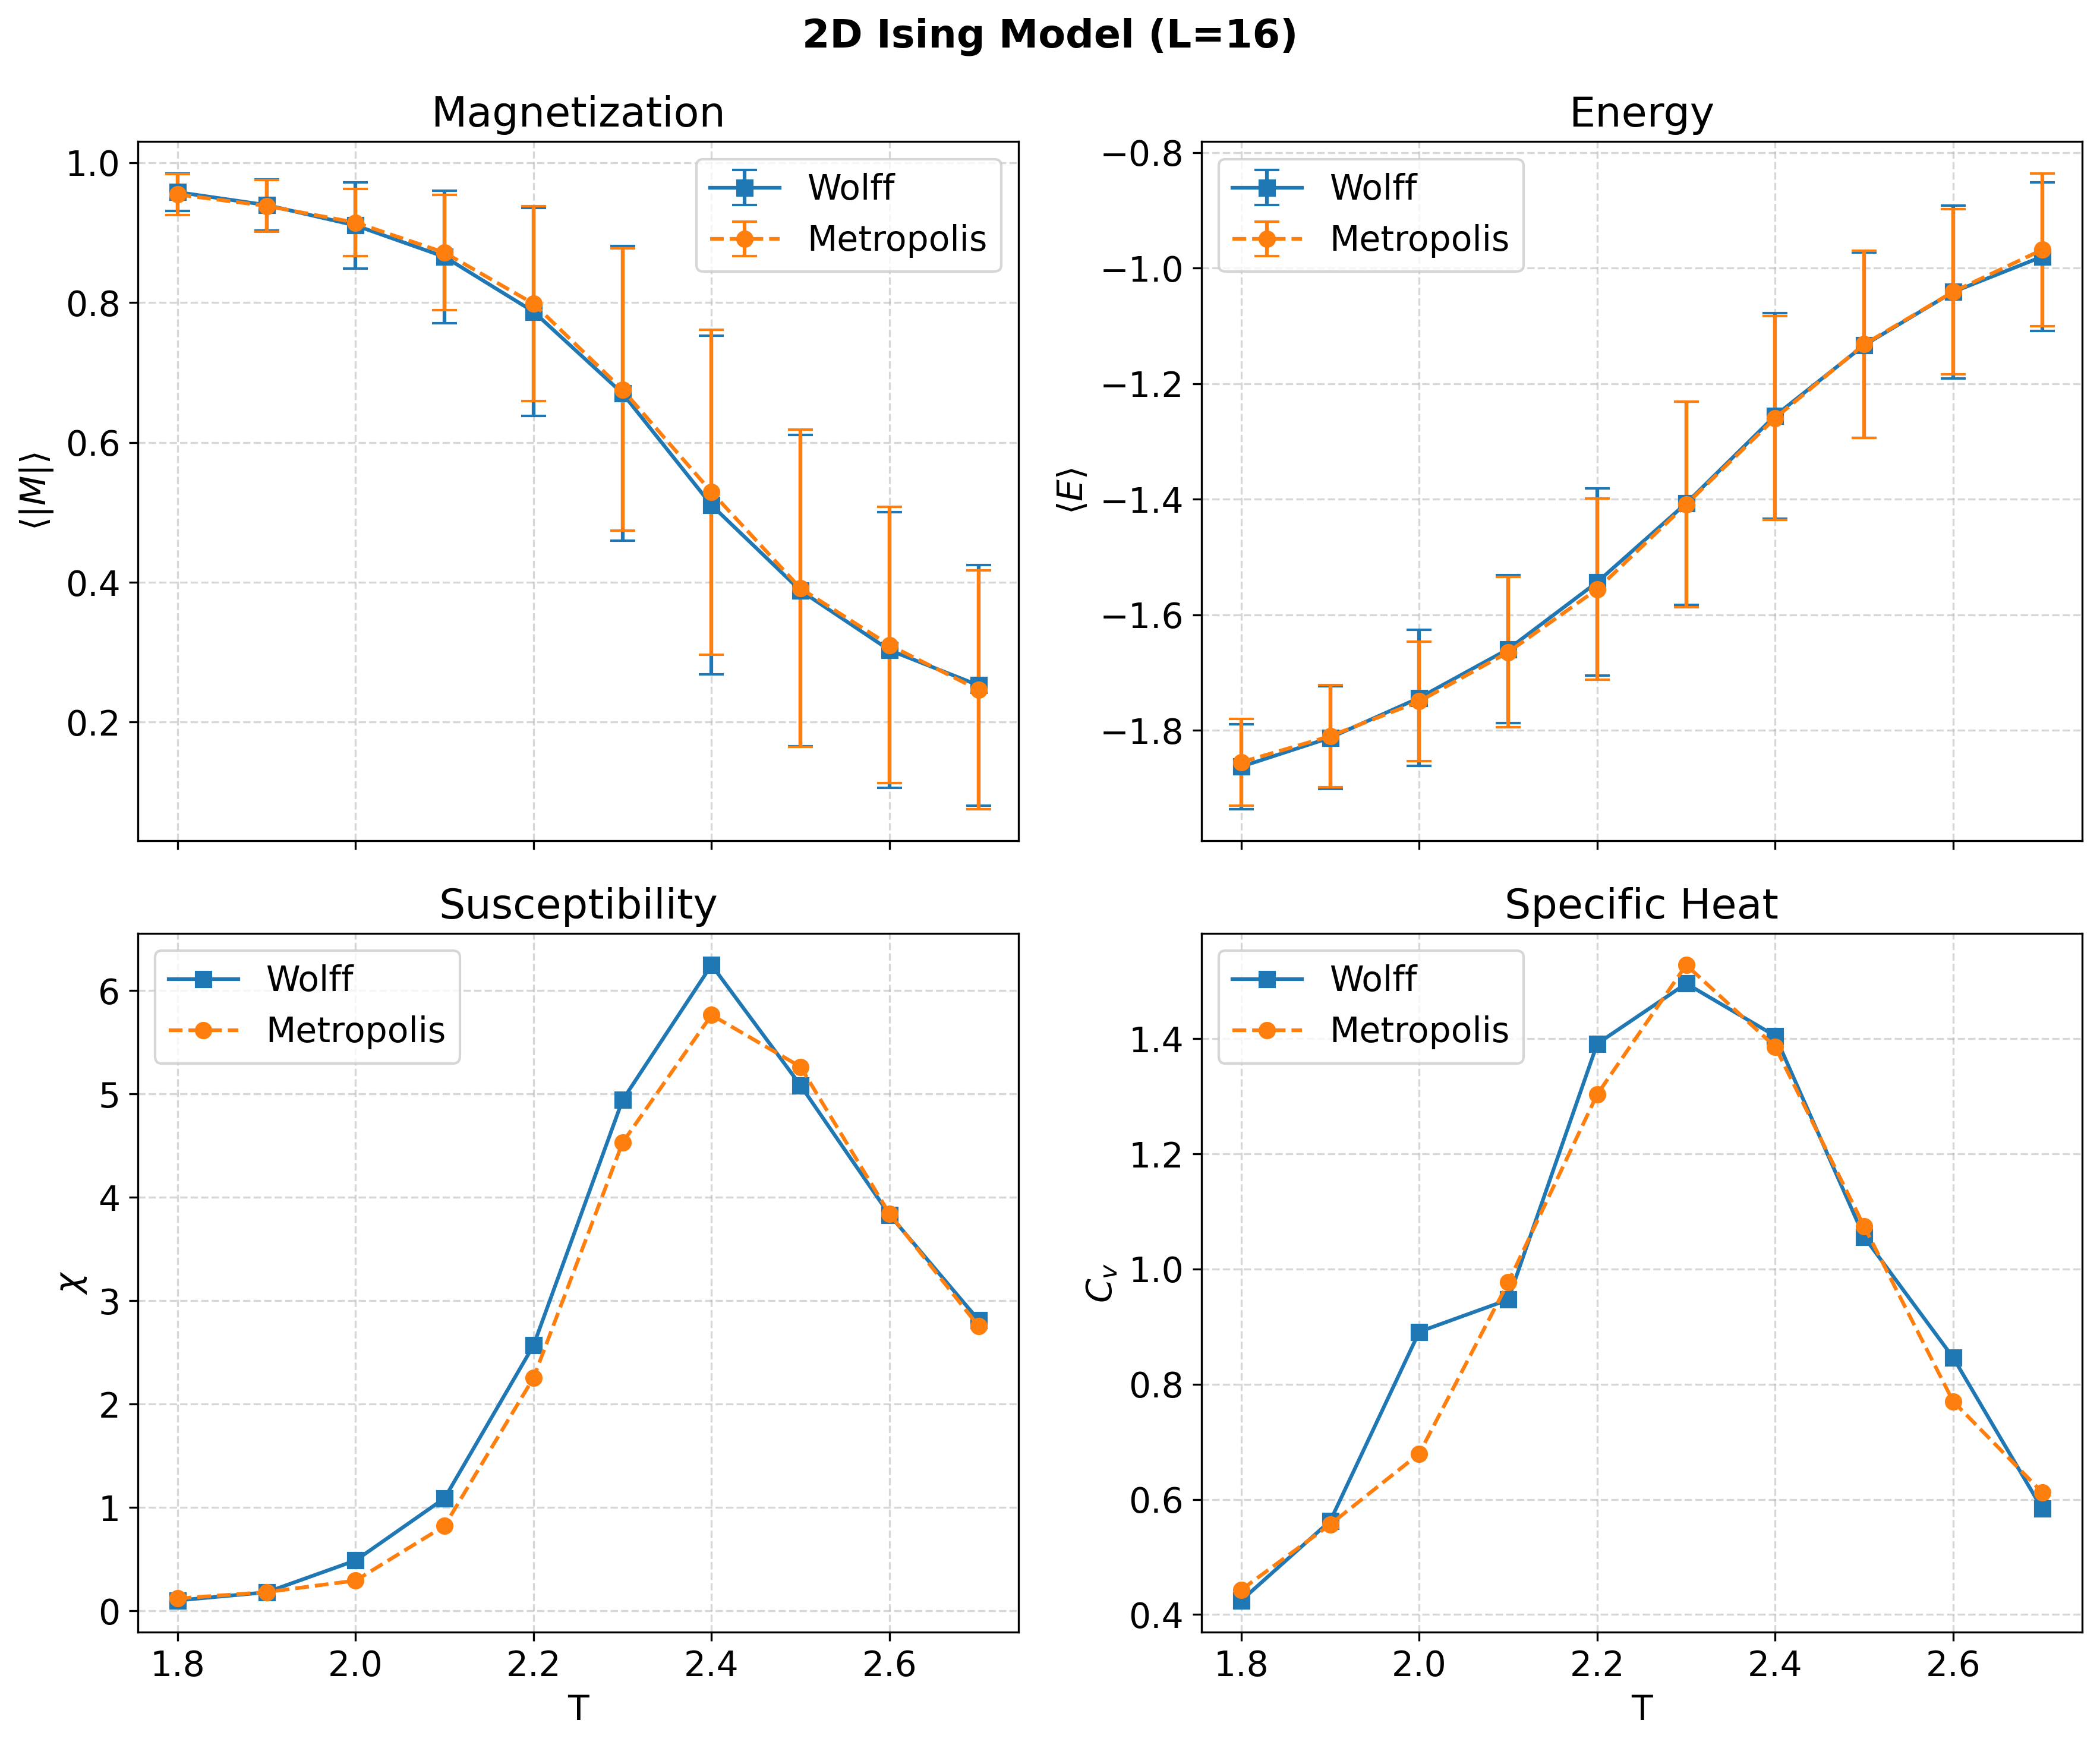

In [293]:
data_metro['T'] = T
data_metro['chi'] = L**2 * (np.array(data_metro['magnetization_std'])**2) / (k_B * T)
data_metro['Cv'] = L**2 * (np.array(data_metro['energy_std'])**2) / (k_B * T**2)
data_wolff['T'] = T
data_wolff['chi'] = L**2 * (np.array(data_wolff['magnetization_std'])**2) / (k_B * T)
data_wolff['Cv'] = L**2 * (np.array(data_wolff['energy_std'])**2) / (k_B * T**2)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300, sharex=True)
axs[0, 0].errorbar(data_wolff['T'], data_wolff['magnetization'], yerr=data_wolff['magnetization_std'], label='Wolff', fmt='s-', capsize=5)
axs[0, 0].errorbar(data_metro['T'], data_metro['magnetization'], yerr=data_metro['magnetization_std'], label='Metropolis', fmt='o--', capsize=5)
axs[0, 0].set_ylabel(r'$\langle |M| \rangle$')
axs[0, 0].set_title('Magnetization')
axs[0, 0].grid(ls='--', alpha=0.5)
axs[0, 0].legend()

axs[0, 1].errorbar(data_wolff['T'], data_wolff['energy'], yerr=data_wolff['energy_std'], label='Wolff', fmt='s-', capsize=5)
axs[0, 1].errorbar(data_metro['T'], data_metro['energy'], yerr=data_metro['energy_std'], label='Metropolis', fmt='o--', capsize=5)
axs[0, 1].set_ylabel(r'$\langle E \rangle$')
axs[0, 1].set_title('Energy')
axs[0, 1].grid(ls='--', alpha=0.5)
axs[0, 1].legend()


axs[1, 0].plot(data_wolff['T'], data_wolff['chi'], 's-', label='Wolff')
axs[1, 0].plot(data_metro['T'], data_metro['chi'], 'o--', label='Metropolis')
axs[1, 0].set_xlabel('T')
axs[1, 0].set_ylabel(r'$\chi$')
axs[1, 0].set_title('Susceptibility')
axs[1, 0].grid(ls='--', alpha=0.5)
axs[1, 0].legend()

axs[1, 1].plot(data_wolff['T'], data_wolff['Cv'], 's-', label='Wolff')
axs[1, 1].plot(data_metro['T'], data_metro['Cv'], 'o--', label='Metropolis')
axs[1, 1].set_xlabel('T')
axs[1, 1].set_ylabel(r'$C_v$')
axs[1, 1].set_title('Specific Heat')
axs[1, 1].grid(ls='--', alpha=0.5)
axs[1, 1].legend()

fig.suptitle(f'2D Ising Model (L={L})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

It can be seen that, under the same total number of spin flips, the Wolff algorithm yields more stable results—both for first-order quantities (energy and magnetization) and second-order quantities (magnetic susceptibility and specific heat).

## Scaling Law and Critical Exponents

The finite-size scaling theroy gives (around $T_c$):
$$
\begin{aligned}
m &\sim L^{-\beta/\nu} \\
C_V &\sim L^{\alpha/\nu} \\
\chi &\sim L^{\gamma/\nu}\\
\langle c\rangle &\sim L^{\gamma/\nu}\\
\tau &\sim L^{z}
\end{aligned}
$$


In [317]:
L = np.array([4, 6, 9, 12, 16, 24, 32, 48])
Tc = 2/np.log(1 + np.sqrt(2))
print('Critical Temperature:', Tc)

Critical Temperature: 2.269185314213022


Similarly, we first estimate the autocorrelation time $\tau$ at $T_c$ for different system sizes $L = [4, 8, 16, 32, 64]$.

In [318]:
tau_wolff_L = []
tau_metro_L = []
cluster_sizes_L = []

# we only compute metropolis upto L=32 due to long autocorrelation time
pbar = tqdm(L, desc="Metropolis")
for l in pbar:
    tau_metro_val = 0
    for _ in range(30):  # repeat to avoid outliers
        s = IsingSpins(l, l, J_val)
        steps_metro_thermal = 300 * l **2
        steps_metro = 500 * l **2
        e_samples, m_samples, _ = sim_ising(s, Tc, steps_metro_thermal, steps_metro, method="metropolis", lag=l**2)
        acf_metro = autocorr_func(m_samples)
        tau_metro_val += integrated_autocorr_time(acf_metro)
    tau_metro_L.append(tau_metro_val/30)
pbar.close()

pbar = tqdm(L, desc="Wolff")
for l in pbar:
    tau_wolff_val = 0
    cluster_size_val = 0
    for _ in range(30):  # repeat to avoid outliers
        s = IsingSpins(l, l, J_val)
        steps_wolff_thermal = 300
        steps_wolff = 500
        e_samples, m_samples, cluster_size = sim_ising(s, Tc, steps_wolff_thermal, steps_wolff, method="wolff", lag=1)
        acf_wolff = autocorr_func(m_samples)
        tau_wolff_val += integrated_autocorr_time(acf_wolff)
        cluster_size_val += cluster_size
    tau_wolff_L.append(tau_wolff_val/30)
    cluster_sizes_L.append(cluster_size_val/30)
pbar.close()

print('tau_metropolis:\n', tau_metro_L)
print('tau_wolff:\n', tau_wolff_L)
print('cluster_sizes:\n', cluster_sizes_L)

Wolff: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it]

tau_metropolis:
 [3.0736542871354433, 5.116618779826625, 9.533460514446578, 13.611447478222013, 19.53920068850898, 30.45938957364552, 39.08449273963946, 36.490405261600024]
tau_wolff:
 [1.0461260167355126, 1.282465354621365, 1.6838634545546318, 1.8737358120599494, 2.0684268132748773, 2.562120751222203, 3.0981229371600025, 3.3258289459117365]
cluster_sizes:
 [11.8, 24.533333333333335, 50.53333333333333, 83.96666666666667, 139.4, 284.8, 467.5, 953.6]


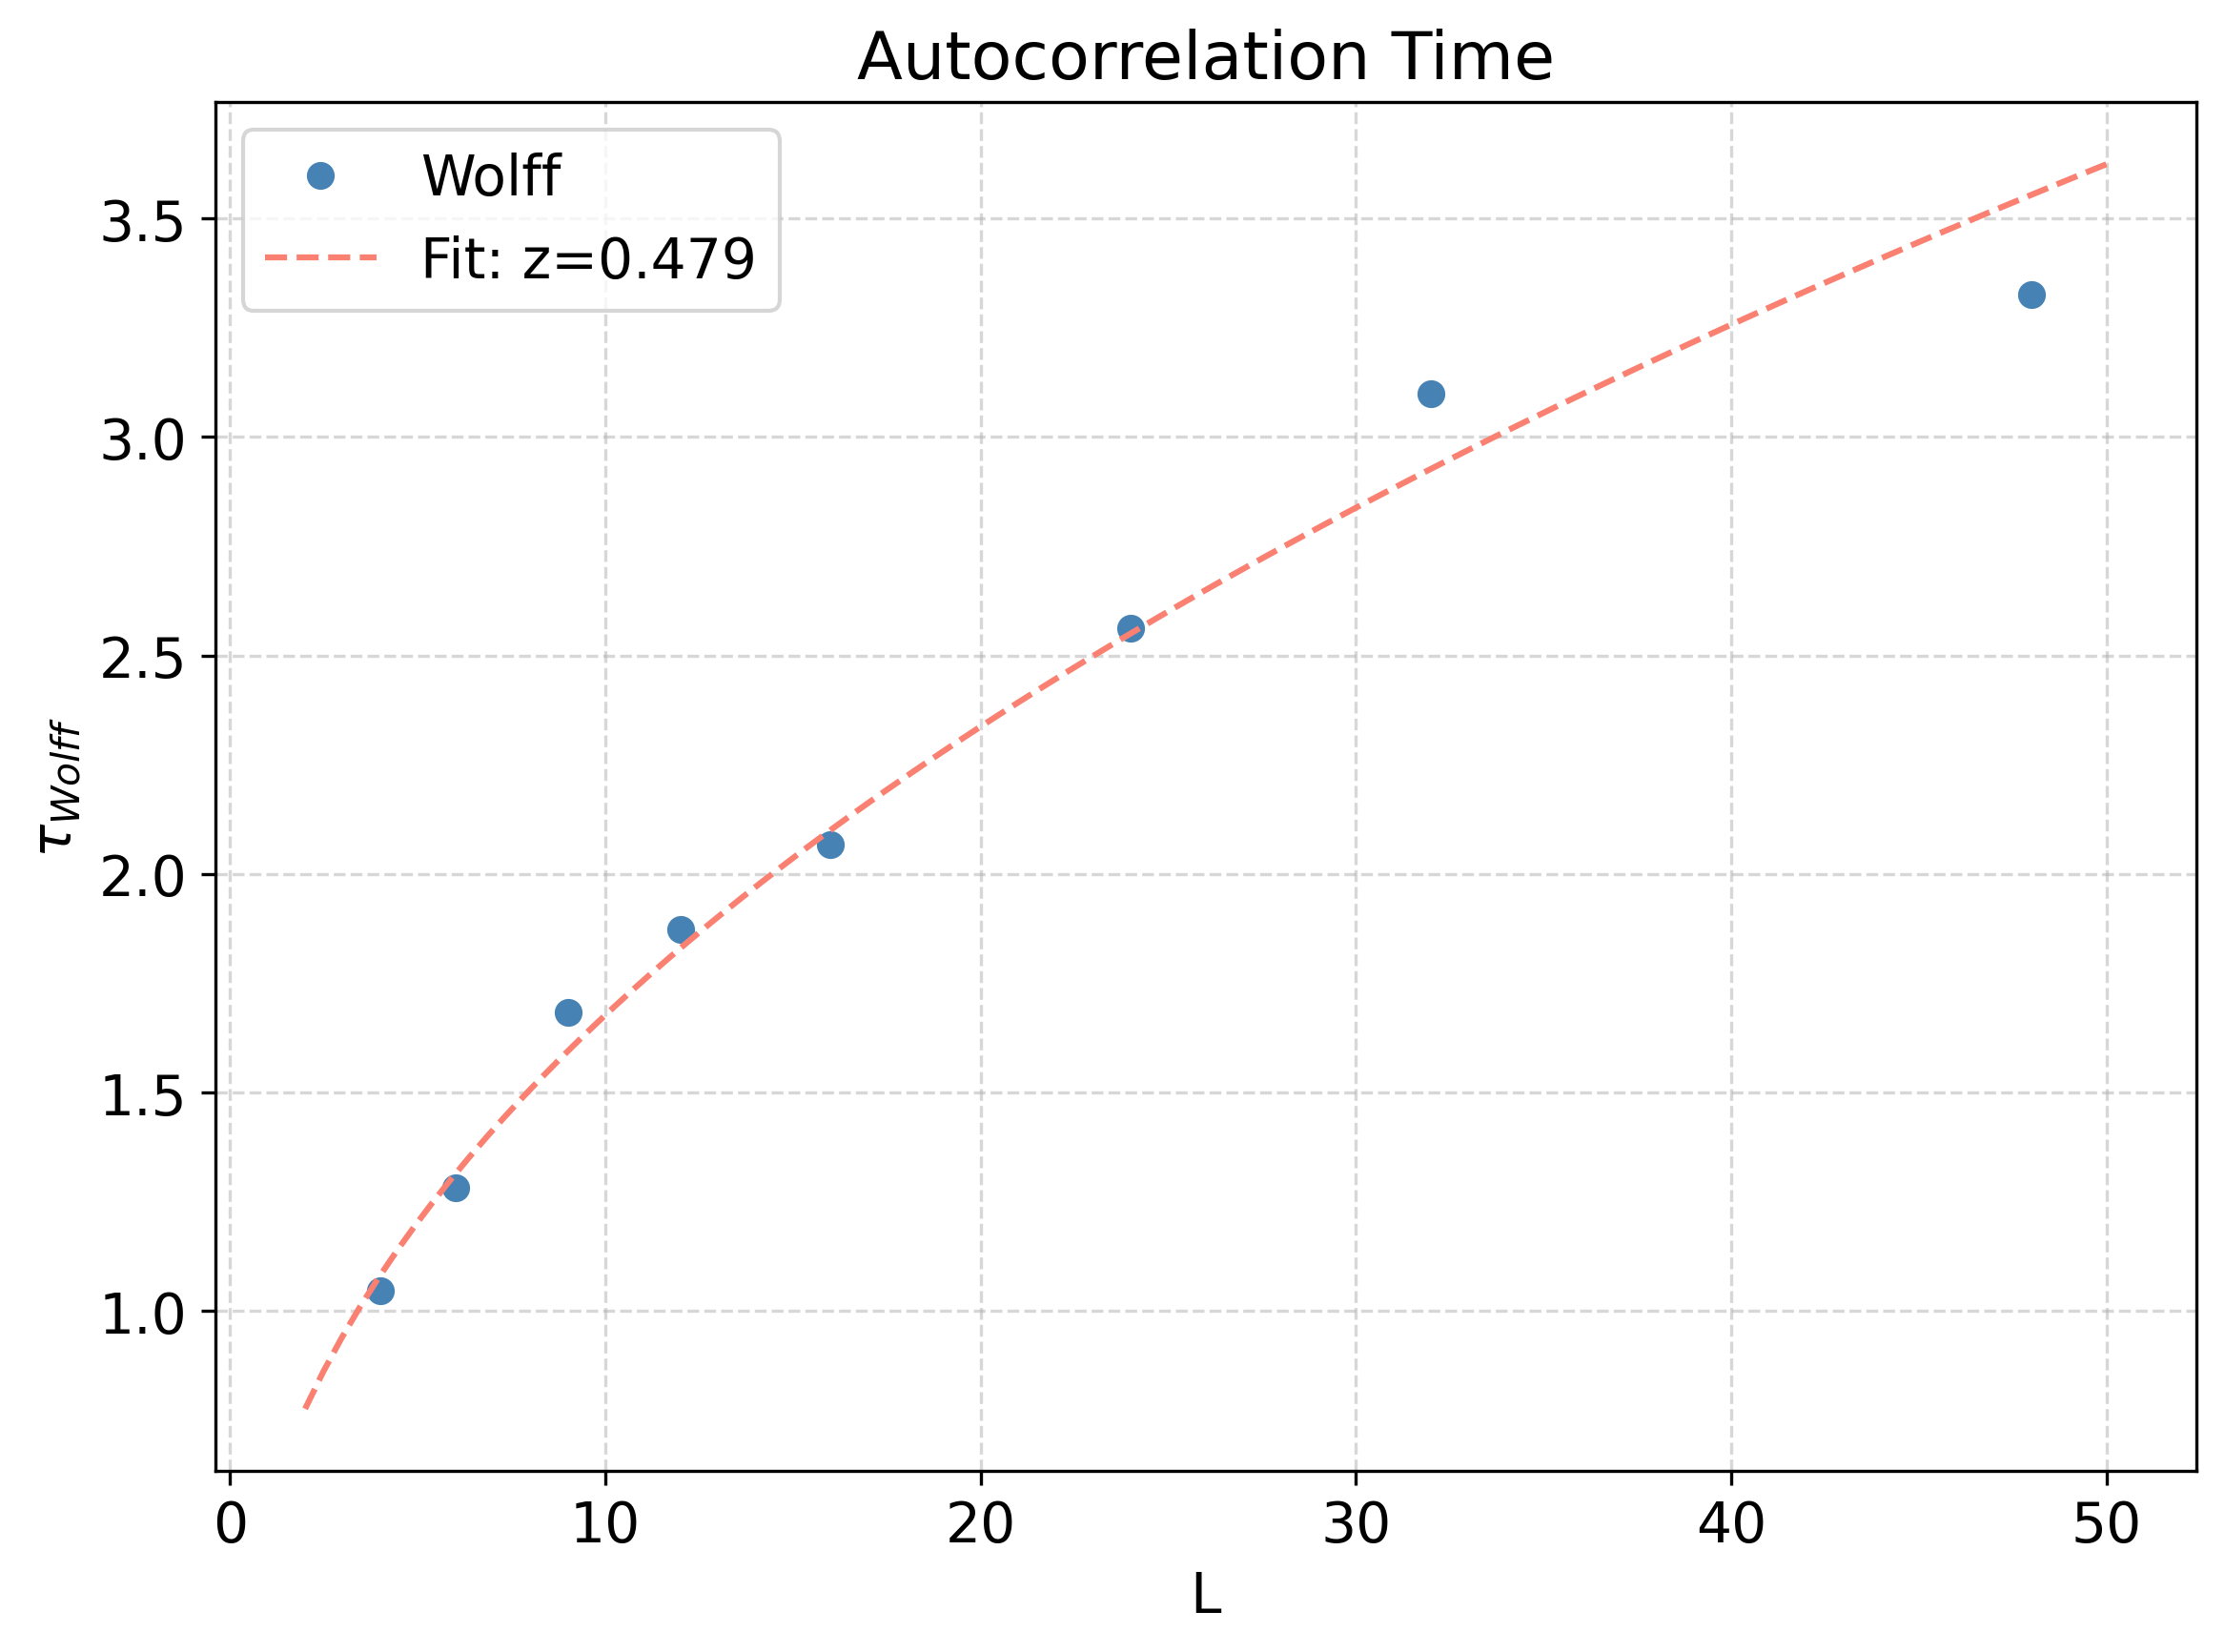

In [320]:
zcf, inter_zcf = np.polyfit(np.log(L), np.log(np.array(tau_wolff_L)), 1)

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.plot(L, tau_wolff_L, 'o', label='Wolff', color='steelblue')
ax.plot(L_fit, np.exp(inter_zcf) * L_fit**zcf, '--', label='Fit: z={:.3f}'.format(zcf), color='salmon')
ax.set_xlabel('L')
ax.set_ylabel(r'$\tau_{Wolff}$')
ax.set_title('Autocorrelation Time')
ax.grid(ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

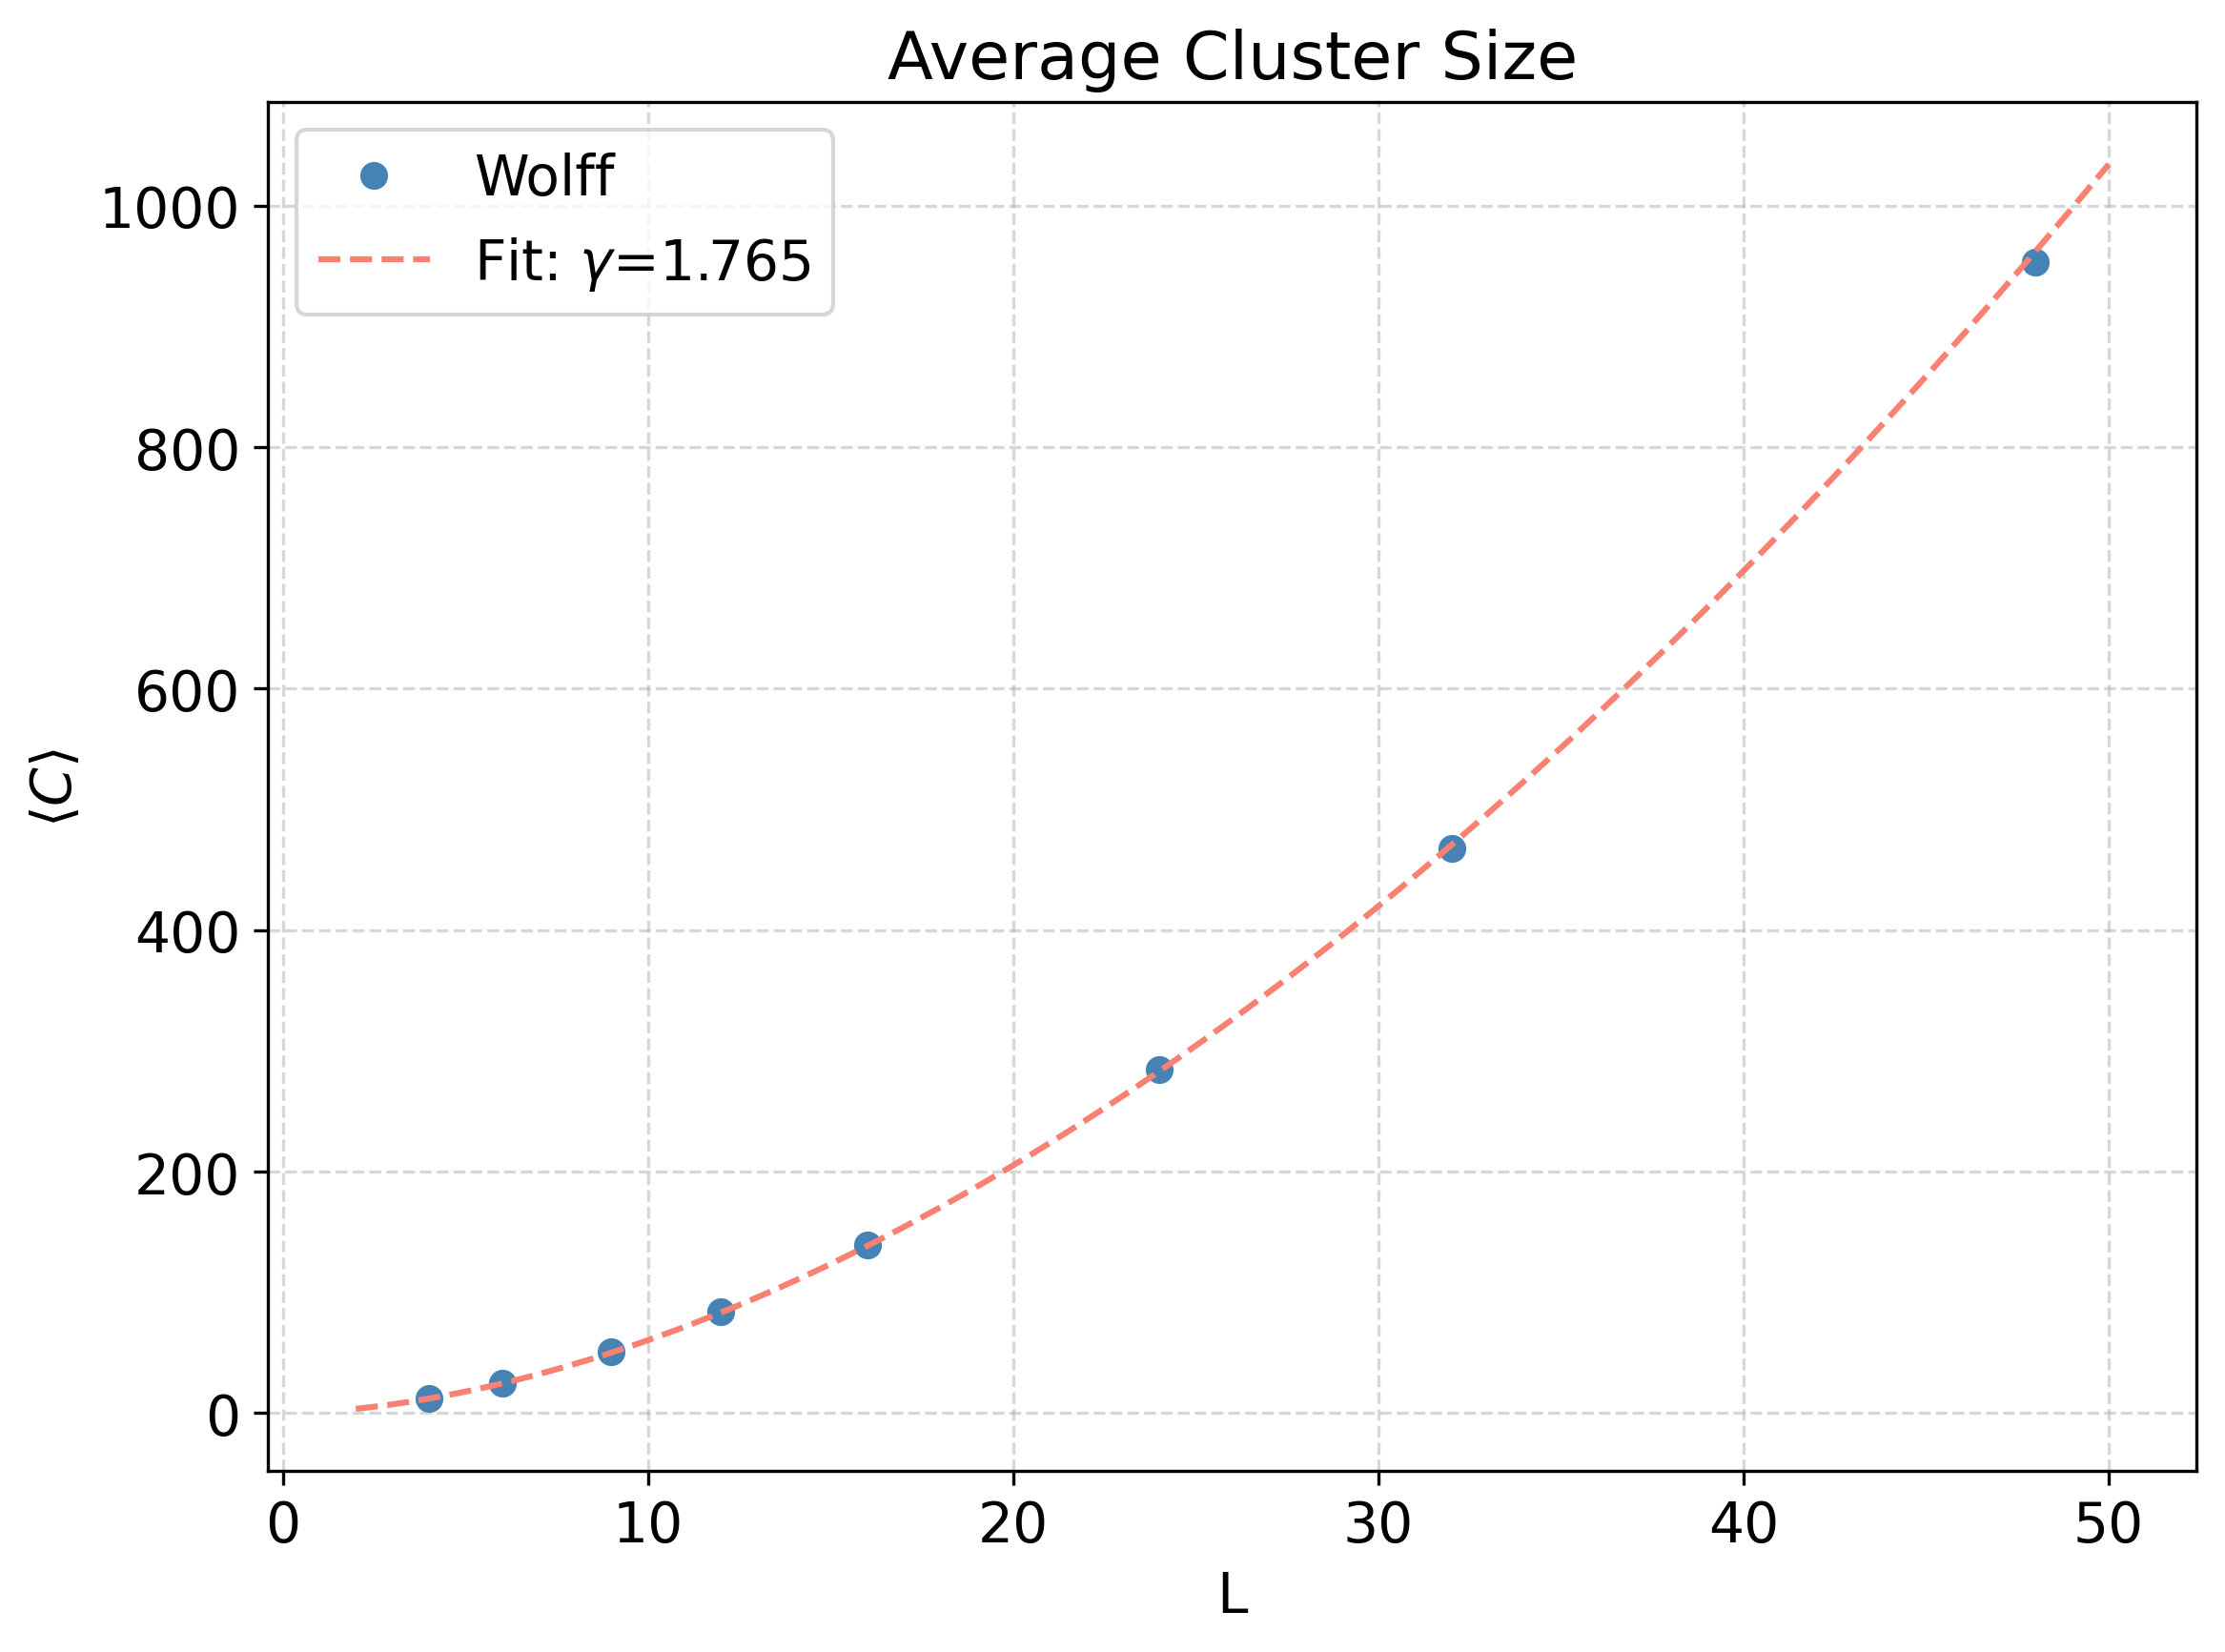

In [332]:
gamma_c, inter_gc = np.polyfit(np.log(L), np.log(cluster_sizes_L), 1)

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.plot(L, cluster_sizes_L, 'o', label='Wolff', color='steelblue')
ax.plot(L_fit, np.exp(inter_gc) * L_fit**gamma_c, '--', label=r'Fit: $\gamma$={:.3f}'.format(gamma_c), color='salmon')
ax.set_xlabel('L')
ax.set_ylabel(r'$\langle C \rangle$')
ax.set_title('Average Cluster Size')
ax.grid(ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

Critical exponent z (Metropolis): 1.080
Critical exponent z (Wolff): 0.244


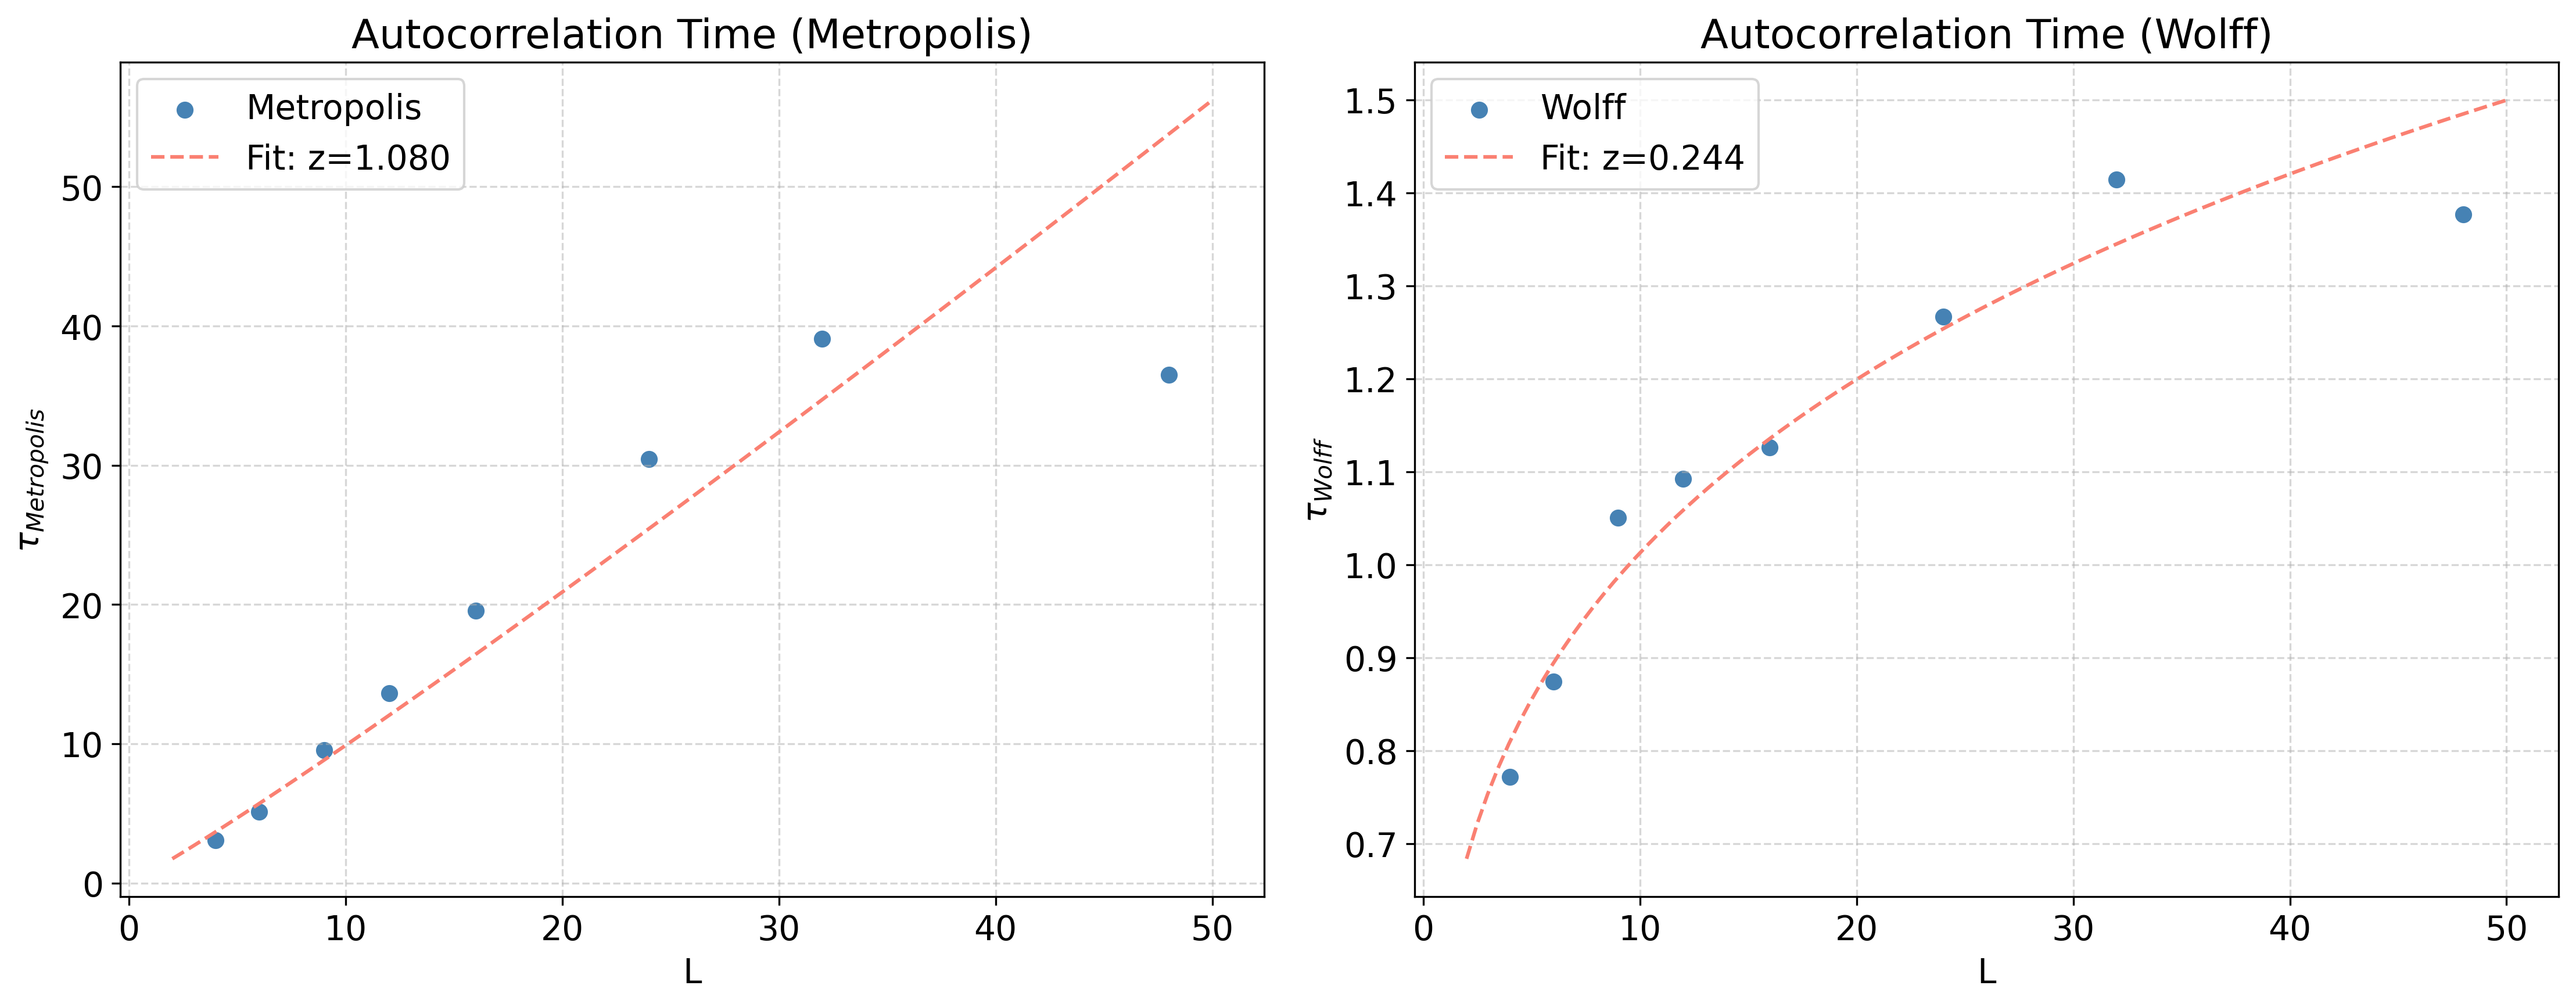

In [326]:
z_metro,inter_zm = np.polyfit(np.log(L), np.log(tau_metro_L), 1)
z_wolff, inter_zw = np.polyfit(np.log(L), np.log(np.array(tau_wolff_L)*np.array(cluster_sizes_L)/np.array(L)**2), 1)

print(f'Critical exponent z (Metropolis): {z_metro:.3f}')
print(f'Critical exponent z (Wolff): {z_wolff:.3f}')

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(1,2, figsize=(15,6),dpi=300)
ax[0].scatter(L, tau_metro_L, label='Metropolis', color='steelblue')
ax[0].plot(L_fit, np.exp(inter_zm) * L_fit**z_metro, '--', label='Fit: z={:.3f}'.format(z_metro), color='salmon')
ax[0].set_xlabel('L') 
ax[0].set_ylabel(r'$\tau_{Metropolis}$')
ax[0].set_title('Autocorrelation Time (Metropolis)')
ax[0].grid(ls='--', alpha=0.5)
ax[0].legend()
ax[1].scatter(L, np.array(tau_wolff_L)*np.array(cluster_sizes_L)/np.array(L)**2, label='Wolff', color='steelblue')
ax[1].plot(L_fit, np.exp(inter_zw) * L_fit**z_wolff, '--', label='Fit: z={:.3f}'.format(z_wolff), color='salmon')
ax[1].set_xlabel('L')
ax[1].set_ylabel(r'$\tau_{Wolff}$')
ax[1].set_title('Autocorrelation Time (Wolff)')
ax[1].grid(ls='--', alpha=0.5)
ax[1].legend()
plt.tight_layout()
plt.show()


In [327]:
data_metro_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

#---- metropolis simulation ----#
pbar = tqdm(L, desc='Metropolis')
for l in pbar:
    i = np.where(L == l)[0][0]
    cluster_size = cluster_sizes_L[i]

    steps_metro_thermal = int(100 * tau_metro_L[i])
    steps_metro = int(3000 * tau_metro_L[i] * l * l)

    s = IsingSpins(l, l, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * Tc, steps_metro_thermal, steps_metro, 'metropolis', int(2*tau_metro_L[i]*l*l))
    data_metro_L['energy'].append(np.mean(e_sam))
    data_metro_L['energy_std'].append(np.std(e_sam))
    data_metro_L['magnetization'].append(np.mean(m_sam))
    data_metro_L['magnetization_std'].append(np.std(m_sam))
pbar.close()

#---- wolff simulation ----#
pbar = tqdm(L, desc='Wolff')
for l in pbar:
    i = np.where(L == l)[0][0]

    steps_wolff_thermal = int(100 * tau_wolff_L[i])
    steps_wolff = int(3000 * tau_wolff_L[i])

    s_w = IsingSpins(l, l, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * Tc, steps_wolff_thermal, steps_wolff, 'wolff', int(2 * tau_wolff_L[i]))
    
    data_wolff_L['energy'].append(np.mean(e_sam))
    data_wolff_L['energy_std'].append(np.std(e_sam))
    data_wolff_L['magnetization'].append(np.mean(m_sam))
    data_wolff_L['magnetization_std'].append(np.std(m_sam))
    data_wolff_L['cluster_size'].append(cluster_size)
pbar.close()

data_metro_L['L'] = L
data_metro_L['chi'] = L**2 * (np.array(data_metro_L['magnetization_std'])**2) / (k_B * Tc)
data_metro_L['Cv'] = L**2 * (np.array(data_metro_L['energy_std'])**2) / (k_B * Tc**2)

data_wolff_L['L'] = L
data_wolff_L['chi'] = L**2 * (np.array(data_wolff_L['magnetization_std'])**2) / (k_B * Tc)
data_wolff_L['Cv'] = L**2 * (np.array(data_wolff_L['energy_std'])**2) / (k_B * Tc**2)


Wolff: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Take $\nu$ as the exact value $1$, we can fit the critical exponents $\beta$, $\gamma$, and $\alpha$ from the datas.

,Method,Beta,Gamma,C0
0,Metropolis,0.117657,1.765053,0.580088
1,Wolff,0.125479,1.796022,0.571727
2,Exact,0.125000,1.750000,0.500000


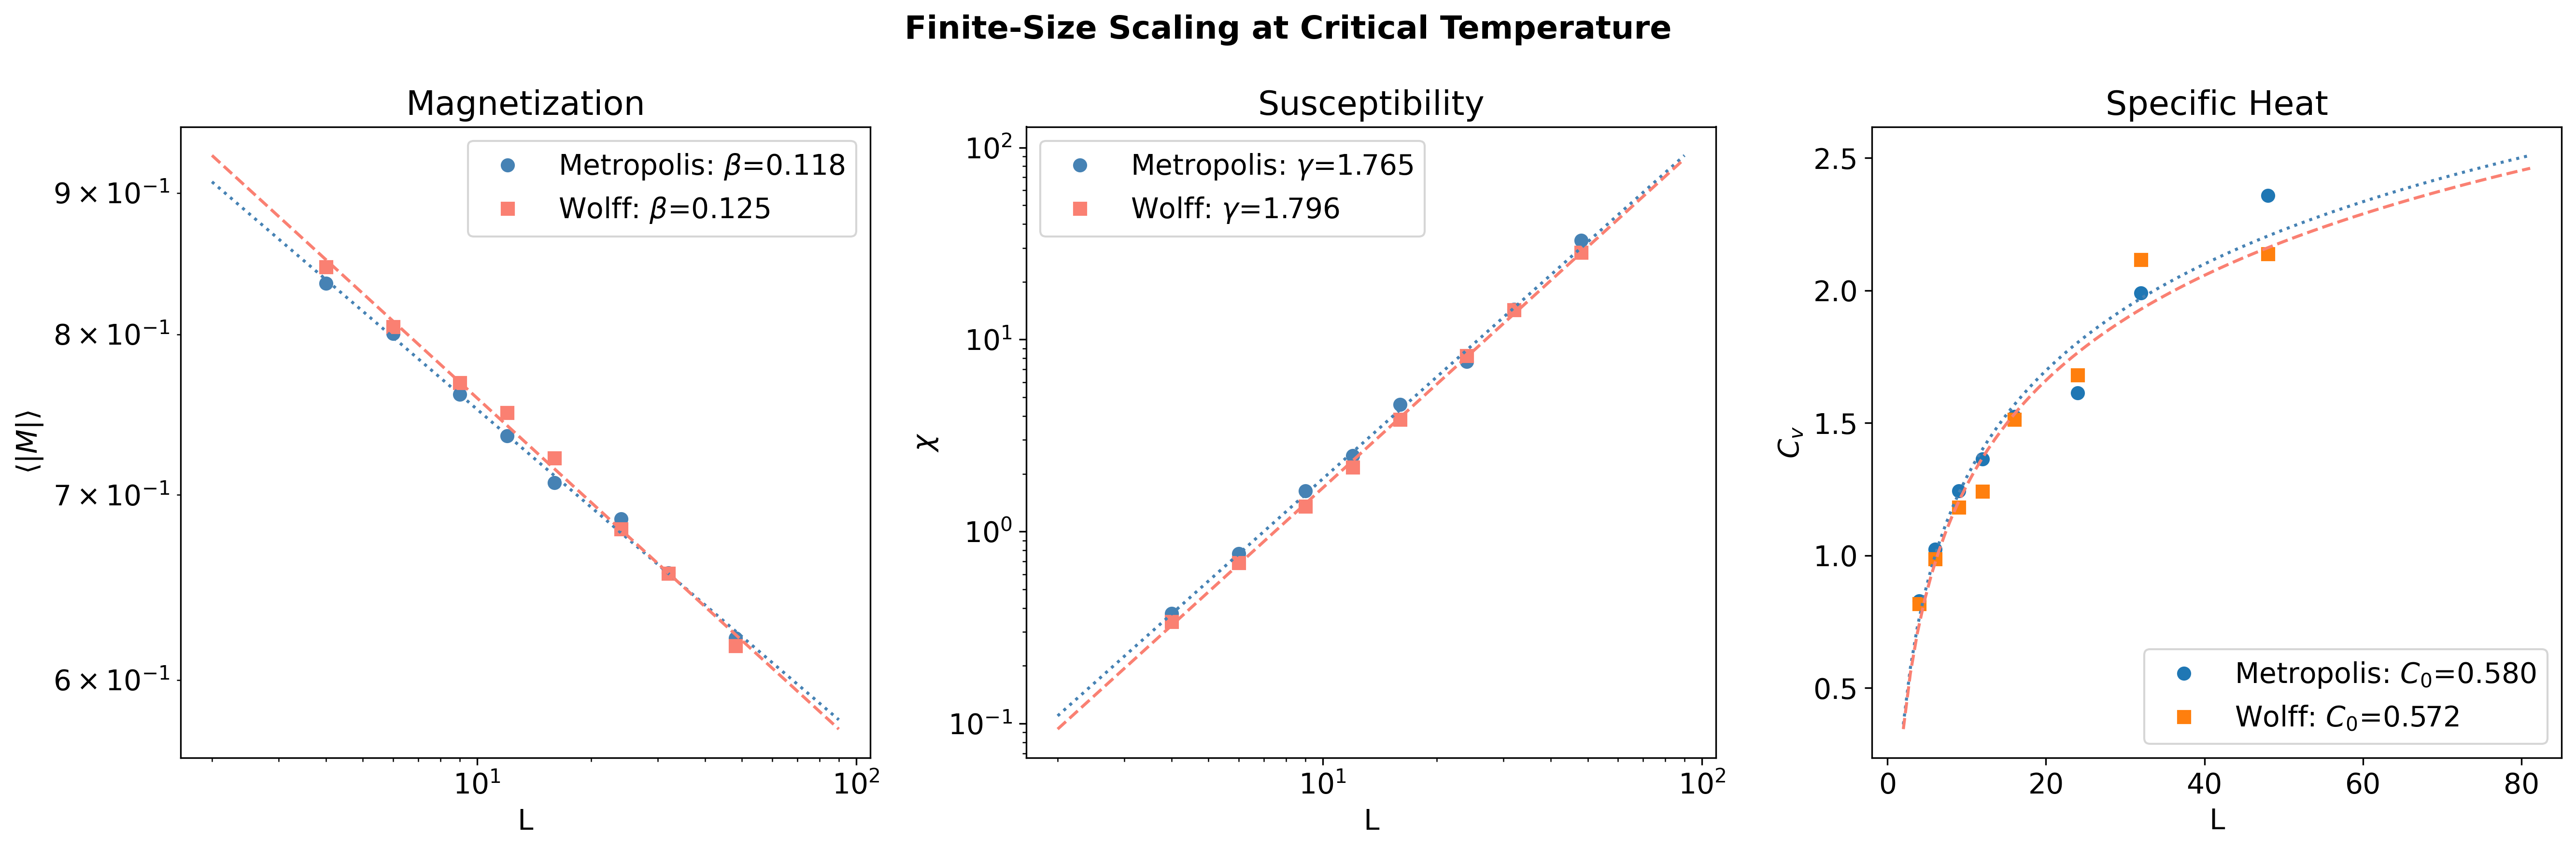

In [335]:
# beta
beta_metro, intercept_beta_metro = np.polyfit(np.log(L), np.log(data_metro_L['magnetization']), 1)
beta_wolff, intercept_beta_wolff = np.polyfit(np.log(L), np.log(data_wolff_L['magnetization']), 1)

# gamma
gamma_metro, intercept_gamma_metro = np.polyfit(np.log(L), np.log(data_metro_L['chi']), 1)
gamma_wolff, intercept_gamma_wolff = np.polyfit(np.log(L), np.log(data_wolff_L['chi']), 1)

# alpha = 0
C0_metro, intercept_C0_metro = np.polyfit(np.log(L), data_metro_L['Cv'], 1)
C0_wolff, intercept_C0_wolff = np.polyfit(np.log(L), data_wolff_L['Cv'], 1)

df_scaling = pd.DataFrame({
    'Method': ['Metropolis', 'Wolff', 'Exact'],
    'Beta': [-beta_metro, -beta_wolff, 0.125],
    'Gamma': [gamma_metro, gamma_wolff, 1.75],
    'C0': [C0_metro, C0_wolff, 0.5],
})

display(df_scaling)

L_fit = np.linspace(2, 90, 100)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
axs[0].loglog(L, data_metro_L['magnetization'], 'o', label=r'Metropolis: $\beta$={:.3f}'.format(-beta_metro),color='steelblue')
axs[0].loglog(L, data_wolff_L['magnetization'], 's', label=r'Wolff: $\beta$={:.3f}'.format(-beta_wolff),color='salmon')
axs[0].loglog(L_fit, np.exp(intercept_beta_metro) * L_fit**beta_metro, ':',color='steelblue')
axs[0].loglog(L_fit, np.exp(intercept_beta_wolff) * L_fit**beta_wolff, '--',color='salmon')
axs[0].set_xlabel('L')
axs[0].set_ylabel(r'$\langle |M| \rangle$')
axs[0].set_title('Magnetization')
axs[0].legend()

axs[1].loglog(L, data_metro_L['chi'], 'o', label=r'Metropolis: $\gamma$={:.3f}'.format(gamma_metro),color='steelblue')
axs[1].loglog(L, data_wolff_L['chi'], 's', label=r'Wolff: $\gamma$={:.3f}'.format(gamma_wolff),color='salmon')
axs[1].loglog(L_fit, np.exp(intercept_gamma_metro) * L_fit**gamma_metro,':',color='steelblue')
axs[1].loglog(L_fit, np.exp(intercept_gamma_wolff) * L_fit**gamma_wolff, '--',color='salmon')
axs[1].set_xlabel('L')  
axs[1].set_ylabel(r'$\chi$')
axs[1].set_title('Susceptibility')
axs[1].legend()

axs[2].plot(L, data_metro_L['Cv'], 'o', label=r'Metropolis: $C_0$={:.3f}'.format(C0_metro))
axs[2].plot(L, data_wolff_L['Cv'], 's', label=r'Wolff: $C_0$={:.3f}'.format(C0_wolff))
axs[2].plot(L_fit[:90], C0_metro*np.log(L_fit[:90]) + intercept_C0_metro, ':', color='steelblue')
axs[2].plot(L_fit[:90], C0_wolff*np.log(L_fit[:90]) + intercept_C0_wolff, '--', color='salmon')
axs[2].set_xlabel('L')
axs[2].set_ylabel(r'$C_v$')
axs[2].set_title('Specific Heat')
axs[2].legend()
fig.suptitle('Finite-Size Scaling at Critical Temperature', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Site-Bond Percolation Cluster

TODO

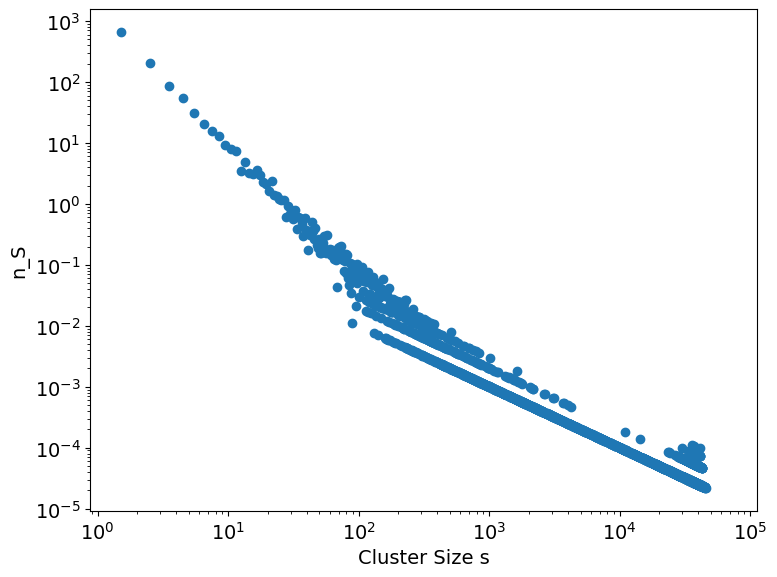

In [86]:
L = 256
Tc = 2/np.log(1 + np.sqrt(2))

steps_wolff_thermal = 2000
steps_wolff = 10000

size = []
s_max = L * L

spins = IsingSpins(L, L, J_val)

multipleSteps(spins, k_B * Tc, steps_wolff_thermal, 'wolff', False)

for _ in range(steps_wolff):
    cluster_size = wolffStep(spins, k_B * Tc)
    size.append(cluster_size)

size = np.array(size)

counts, bin_edges = np.histogram(size, bins=s_max, range=(1, s_max))

s_vals = bin_edges[:-1] + 0.5

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.loglog(s_vals, counts/s_vals, 'o', label=f'L={L}')
ax.set_xlabel('Cluster Size s')
ax.set_ylabel(r'n_S')
plt.tight_layout()
plt.show()

## Phase Classification

Convolutional Neural Network (CNN) is perfect for phase classification tasks of 2D Ising model due to its ability to capture spatial hierarchies in data. In 2D Ising model, we want the CNN can identify 3 kinds of patterns: 

1. Ordered phase of ferromagnet where spins align to form large clusters.
2. Ordered phase of antiferromagnet where spins align in a checkerboard pattern.
3. Disordered phase where spins are randomly oriented.

In [336]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.patches as patches

We use Monte Carlo simulations (Wolff algorithm) to generate spin configurations at various temperatures.

In [338]:
torch.manual_seed(42)
np.random.seed(42)

Tc = 2 / np.log(1 + np.sqrt(2))

def generate_three_phase_data(n_samples=2000, L=32):
    """
    Generate synthetic Ising model data for three phases:
    Label 0: Disordered 
    Label 1: ferromagnetic (FM)
    Label 2: antiferromagnetic (AFM)
    """
    data = []
    labels = []
    pbar = tqdm(range(n_samples), desc="Generating Data")
    for _ in pbar:
        # randomly select a phase (0, 1, 2)
        label = np.random.randint(0, 3)
        if label == 0:
            # --- Label 0: Disordered ---
            T = np.random.uniform(Tc+0.1, 5.0)  # High temperature range
            s = IsingSpins(L, L, 1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
        elif label == 1:
            # --- Label 1: Ferromagnetic (FM) ---
            T = np.random.uniform(1.5, Tc - 0.1)  # Low temperature range
            s = IsingSpins(L, L, 1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
        else: # label == 2
            # --- Label 2: Antiferromagnetic (AFM) ---
            T = np.random.uniform(1.5, Tc - 0.1)  # Low temperature range
            s = IsingSpins(L, L, -1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
    
        data.append(snapshot)
        labels.append(label)
    pbar.close()
    # CNN input dimensions: (Batch, Channels=1, Height, Width)
    X = torch.tensor(np.array(data), dtype=torch.float32).unsqueeze(1) 
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

# Set standard size and data amount
L = 32
X, y = generate_three_phase_data(n_samples=3000, L=L)

# Split and load
train_size = int(0.8 * len(X))
train_dataset = TensorDataset(X[:train_size], y[:train_size])
test_dataset = TensorDataset(X[train_size:], y[train_size:])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Data generation complete, size: {L}x{L}")
print(f"Training samples: {len(train_dataset)}, test samples: {len(test_dataset)}")

Generating Data: 100%|██████████| 3000/3000 [00:33<00:00, 90.00it/s] 

Data generation complete, size: 32x32
Training samples: 2400, test samples: 600


Select examples for each phase to display the characteristic patterns.

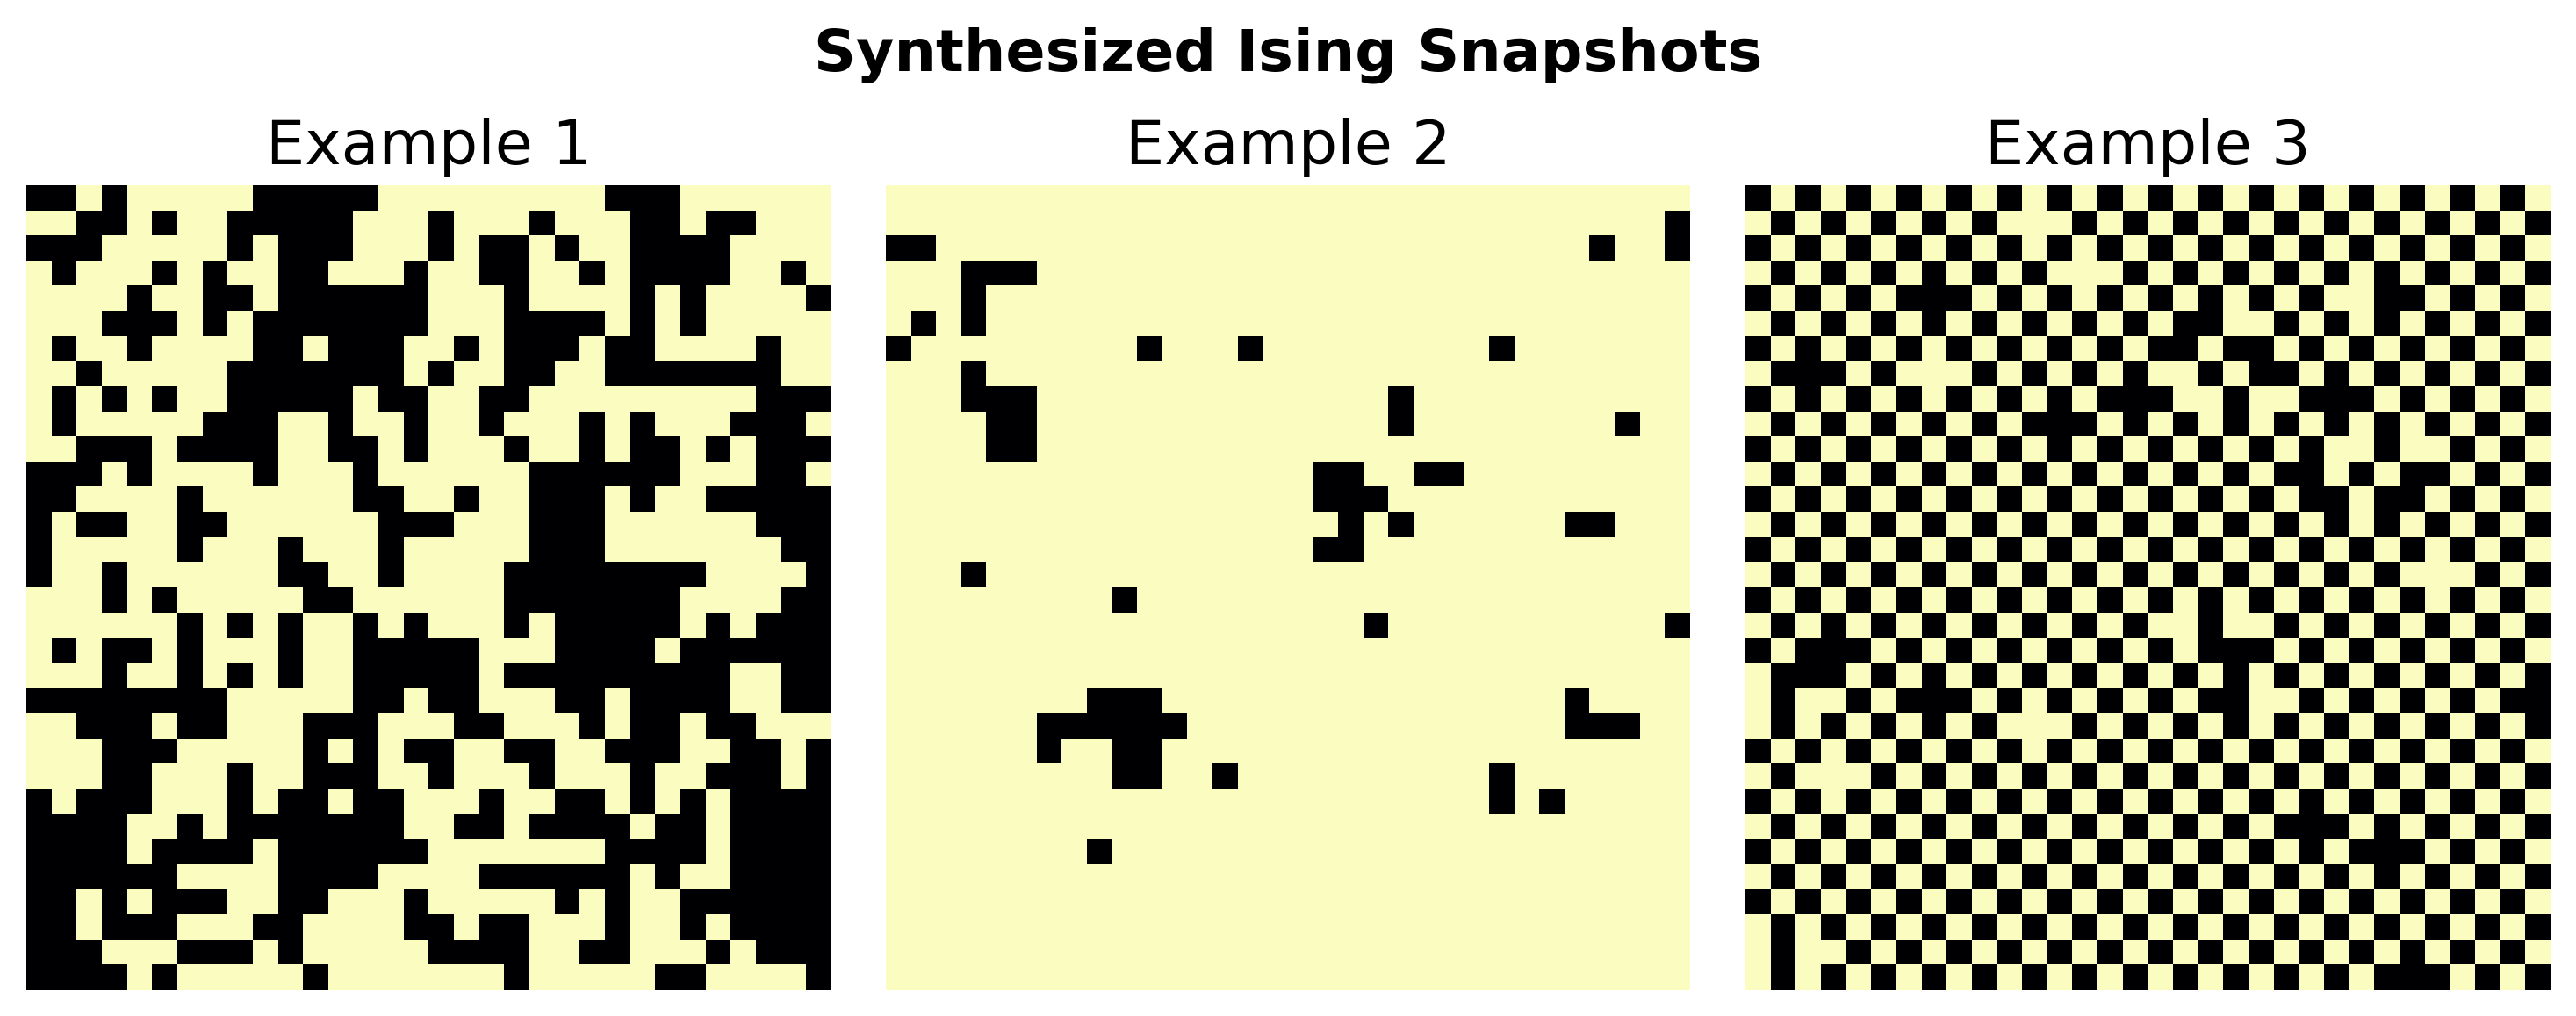

In [340]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4),dpi=300)

# Select examples for each phase
samples = [X[y==0][0], X[(y==1) & (X.mean(dim=(1,2,3)) > 0.5)][0], X[(y==2) & (X.mean(dim=(1,2,3)).abs() < 0.2)][0]]

for i, ax in enumerate(axes):
    ax.imshow(samples[i].squeeze(), cmap='magma', vmin=-1, vmax=1)
    ax.set_title(f"Example {i+1}")
    ax.axis('off')
fig.suptitle("Synthesized Ising Snapshots", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [424]:
class TriplePhaseClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TriplePhaseClassifier, self).__init__()
        
        # Define convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            # 4 filters for 4 special patterns
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Block 2
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # # Block 3
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
        )
        
        # Regardless of input image size, after feature extraction, pooling compresses it to 64 channels * 1x1 size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Input dimension fixed to the output channels of Block 3, which is 64
        self.classifier = nn.Sequential(
            nn.Linear(64, num_classes) # Output 3 classes
        )

    def get_embedding(self, x):
        # Extract feature embeddings before classification.
        x = self.features(x)
        x = self.adaptive_pool(x)
        return x.view(x.size(0), -1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) 
    
        # Classify
        x = self.classifier(x)
        return x

In [425]:
class EasyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EasyModel, self).__init__()
        
        # Define convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            # 4 filters for 4 special patterns
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Block 2
            nn.Conv2d(4, 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Regardless of input image size, after feature extraction, pooling compresses it to 64 channels * 1x1 size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Input dimension fixed to the output channels of Block 3, which is 64
        self.classifier = nn.Sequential(
            nn.Linear(2, num_classes) # Output 3 classes
        )

    def get_embedding(self, x):
        # Extract feature embeddings before classification.
        x = self.features(x)
        x = self.adaptive_pool(x)
        return x.view(x.size(0), -1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) 
    
        # Classify
        x = self.classifier(x)
        return x

In [431]:
model = TriplePhaseClassifier(num_classes=3)
# model = EasyModel(num_classes=3)
print("Model architecture:\n", model)

Model architecture:
 TriplePhaseClassifier(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=3, bias=True)
  )
)


Training CNN on cuda for 30 epochs...


Training: 100%|██████████| 30/30 [00:02<00:00, 13.67it/s, Loss=0.0015]


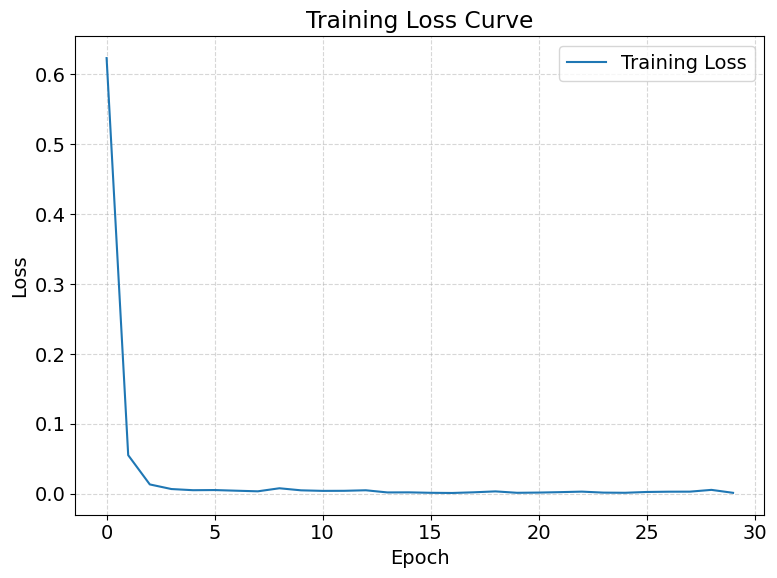

In [432]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
loss_history = []

print(f"Training CNN on {device} for {epochs} epochs...")

pbar = tqdm(range(epochs), desc="Training")
for epoch in pbar:
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    
    pbar.set_postfix({"Loss": f"{epoch_loss:.4f}"})

pbar.close()

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(loss_history, label="Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Curve")
ax.legend()
ax.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [433]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.2%}")

Test Accuracy: 100.00%


The test accuracy reaches over 99%, indicating the CNN's effectiveness in distinguishing between different phases of the 2D Ising model.

tensor([[[[ 0.4143,  0.1622, -0.0095],
          [ 0.2004,  0.1874, -0.2870],
          [ 0.0707,  0.2627, -0.2193]]],


        [[[-0.1095, -0.1992,  0.3114],
          [-0.3376,  0.0854, -0.2802],
          [ 0.3593, -0.2386,  0.2022]]],


        [[[-0.2547, -0.1815, -0.0556],
          [-0.0570, -0.2736, -0.3271],
          [-0.2730, -0.2372,  0.1076]]],


        [[[ 0.1998, -0.2662, -0.1878],
          [ 0.3396, -0.3507,  0.3966],
          [-0.0265, -0.3678,  0.2345]]]])


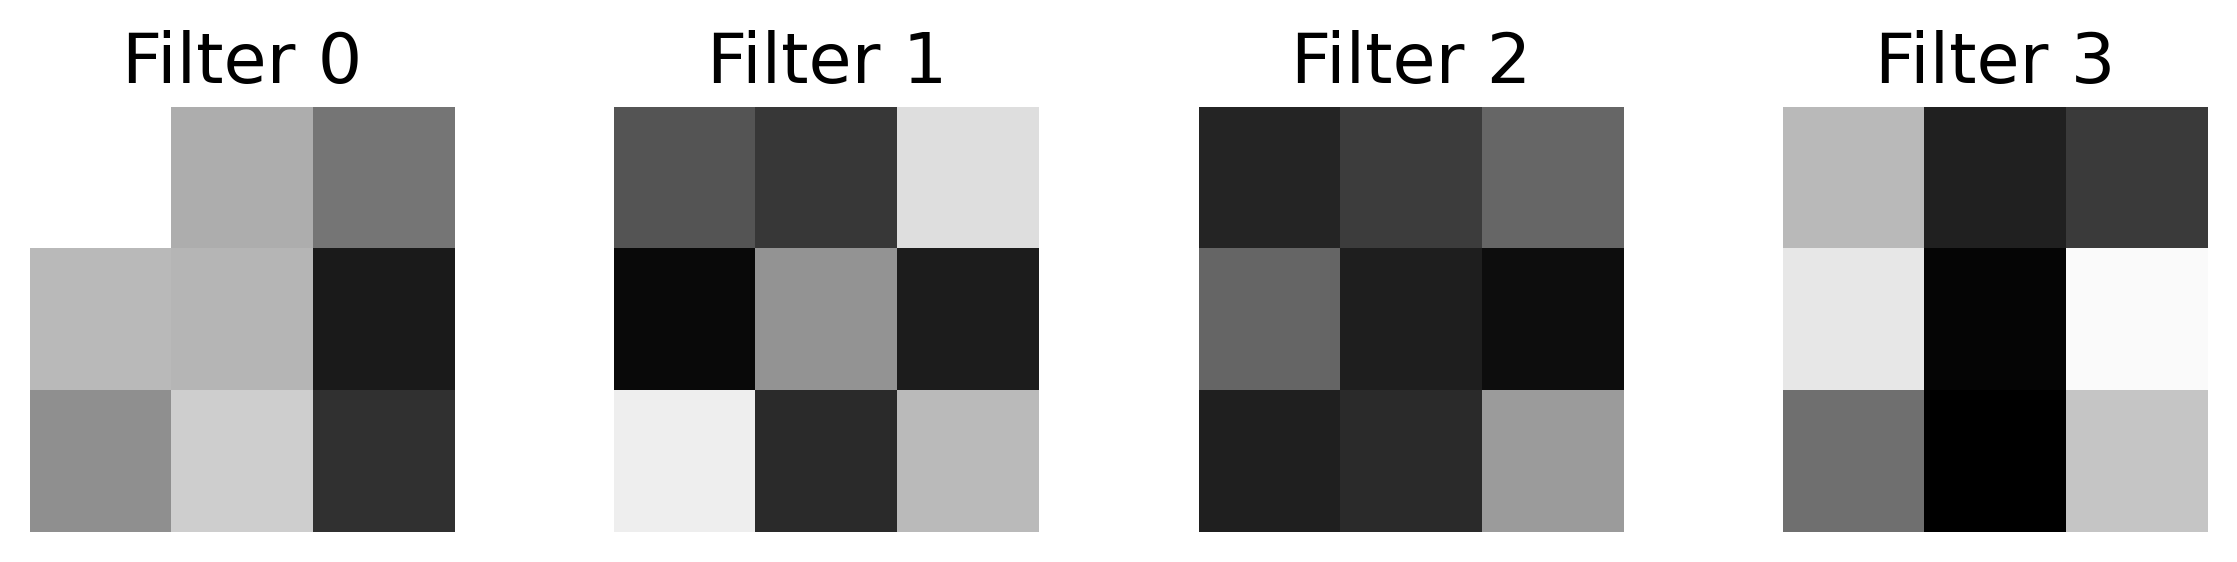

In [434]:
W = model.features[0].weight.detach().cpu()
print(W)

fig, axes = plt.subplots(1, 4, figsize=(8, 2), dpi=300)

for i in range(4):
    ax = axes[i]
    ax.imshow(W[i, 0], cmap='gray', vmin=W.min(), vmax=W.max())
    ax.set_title(f'Filter {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


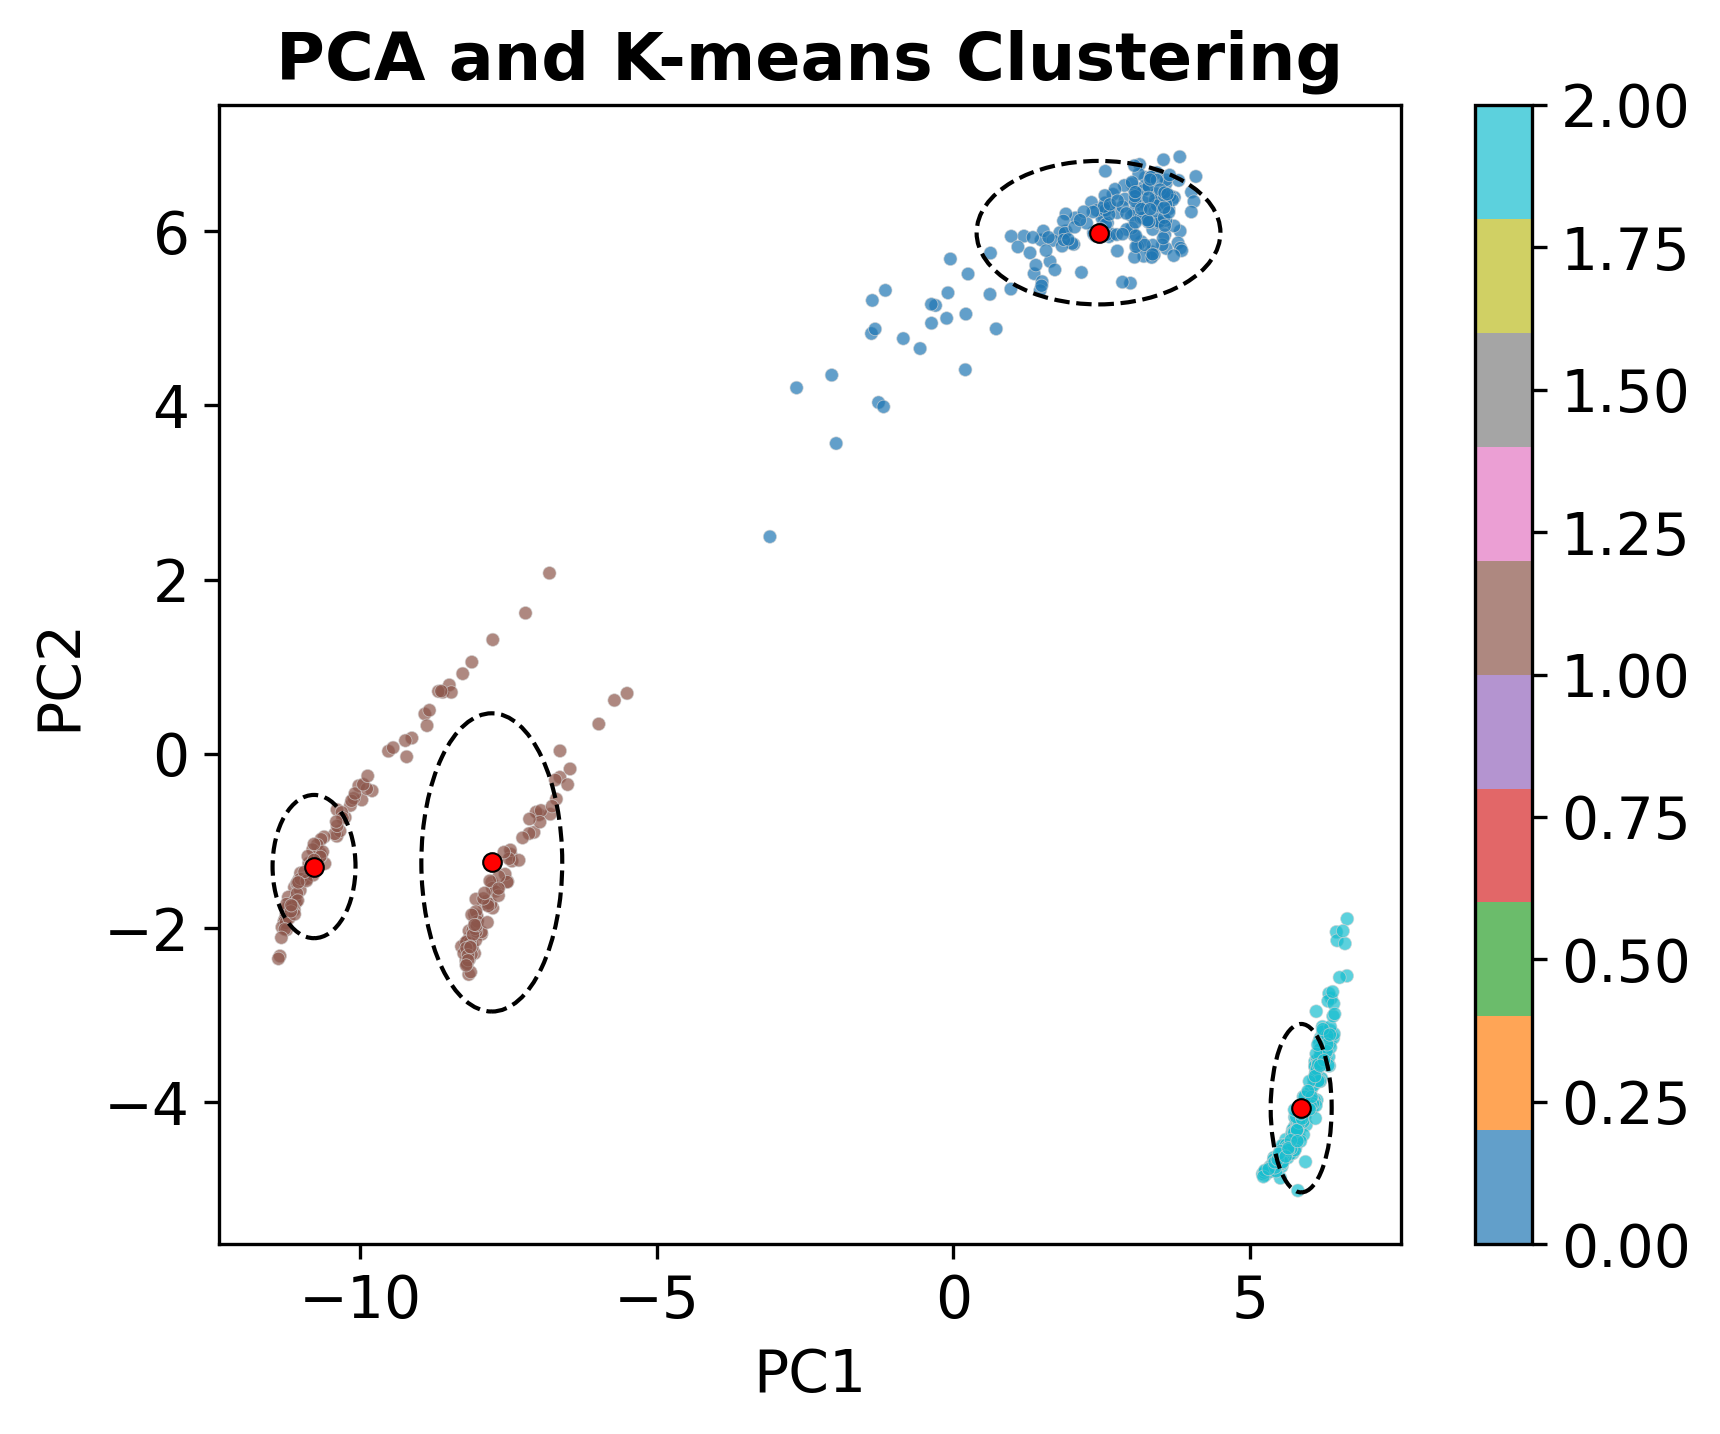

In [435]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model.get_embedding(x)    
        embeddings.append(z.cpu())
        labels.append(y)

embeddings = torch.cat(embeddings).numpy()  
labels = torch.cat(labels).numpy()

# embeddings from previous step
X = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=2)
Z = pca.fit_transform(X)

# k-means clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(Z)


fig, ax = plt.subplots(figsize=(6,5), dpi=300)
scatter = ax.scatter(Z[:,0], Z[:,1], c=labels, cmap='tab10', s=10, alpha=0.7, edgecolors='lightgray', linewidth=0.2)

# plot cluster centers and 3 sigma circles
for i in range(k):
    cluster_points = Z[cluster_labels == i]
    center = cluster_points.mean(axis=0)
    std_dev = cluster_points.std(axis=0)
    
    # plot center
    ax.scatter(center[0], center[1], c='r', s=20, marker='o', edgecolors='black', linewidth=0.5)

    # plot 3-sigma circle
    ellipse = patches.Ellipse((center[0], center[1]), width=3*std_dev[0], height=3*std_dev[1], edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
    ax.add_patch(ellipse)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA and K-means Clustering', fontsize=16, fontweight='bold')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()